## Define the Convolutional Neural Network

In this notebook and in `models.py`, I will:
1. Define a CNN with images as input and keypoints as output
2. Construct the transformed FaceKeypointsDataset, just as before
3. Train the CNN on the training data, tracking loss
4. See how the trained model performs on test data
5. If necessary, modify the CNN structure and model hyperparameters, so that it performs *well* **\***

**\*** What does *well* mean?

"Well" means that the model's loss decreases during training **and**, when applied to test image data, the model produces keypoints that closely match the true keypoints of each face. And you'll see examples of this later in the notebook.

---


## CNN Architecture

Recall that CNN's are defined by a few types of layers:
* Convolutional layers
* Maxpooling layers
* Fully-connected layers

I referenced some literature on keypoint detection, such as [this paper](https://arxiv.org/pdf/1710.00977.pdf), to help determine the structure of my network to prevent overfitting.


### Define model in the provided file `models.py` file


---

## PyTorch Neural Nets

To define a neural network in PyTorch, you define the layers of a model in the function `__init__` and define the feedforward behavior of a network that employs those initialized layers in the function `forward`, which takes in an input image tensor, `x`. The structure of this Net class is shown below.

Note: During training, PyTorch will be able to perform backpropagation by keeping track of the network's feedforward behavior and using autograd to calculate the update to the weights in the network.

#### Define the Layers in ` __init__`
As a reminder, a conv/pool layer may be defined like this (in `__init__`):
```
# 1 input image channel (for grayscale images), 32 output channels/feature maps, 3x3 square convolution kernel
self.conv1 = nn.Conv2d(1, 32, 3)

# maxpool that uses a square window of kernel_size=2, stride=2
self.pool = nn.MaxPool2d(2, 2)      
```

#### Refer to Layers in `forward`
Then referred to in the `forward` function like this, in which the conv1 layer has a ReLu activation applied to it before maxpooling is applied:
```
x = self.pool(F.relu(self.conv1(x)))
```

Best practice is to place any layers whose weights will change during the training process in `__init__` and refer to them in the `forward` function; any layers or functions that always behave in the same way, such as a pre-defined activation function, should appear *only* in the `forward` function.

#### Why models.py

It is better to define the network in the `models.py` file so that any models defined can be saved and loaded by name in different notebooks in this project directory. For example, by defining a CNN class called `Net` in `models.py`, you can then create that same architecture in this and other notebooks by simply importing the class and instantiating a model:
```
    from models import Net
    net = Net()
```

In [1]:
# import the usual resources
import matplotlib.pyplot as plt
import numpy as np

# watch for any changes in model.py, if it changes, re-load it automatically

%load_ext autoreload
%autoreload 2

In [2]:
## TODO: Define the Net in models.py
import torch
import torch.nn as nn
import torch.nn.functional as F

## TODO: Once you've define the network, you can instantiate it
# one example conv layer has been provided for you
from models import Net

In [3]:
net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=30976, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=1000, bias=True)
  (fc3): Linear(in_features=1000, out_features=136, bias=True)
  (drop1): Dropout(p=0.2, inplace=False)
  (drop2): Dropout(p=0.2, inplace=False)
)


In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net = net.to(device)

## Transform the dataset 

To prepare for training, create a transformed dataset of images and keypoints.

### TODO: Define a data transform

In PyTorch, a convolutional neural network expects a torch image of a consistent size as input. For efficient training, and so the model's loss does not blow up during training, it is also advised to normalize the input images and keypoints. The necessary transforms have been defined in `data_load.py`

To define the data transform below, use a [composition](http://pytorch.org/tutorials/beginner/data_loading_tutorial.html#compose-transforms) of:
1. Rescaling and/or cropping the data, such that you are left with a square image (the suggested size is 224x224px)
2. Normalizing the images and keypoints; turning each RGB image into a grayscale image with a color range of [0, 1] and transforming the given keypoints into a range of [-1, 1]
3. Turning these images and keypoints into Tensors

These transformations have been defined in `data_load.py`, and I'll call them and create a `data_transform` below. **This transform will be applied to the training data and, later, the test data**. These steps are essential for efficient training.

In [5]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# the dataset I created in Notebook 1 is copied in the helper file `data_load.py`
from data_load import FacialKeypointsDataset
# the transforms I defined in Notebook 1 are in the helper file `data_load.py`
from data_load import Rescale, RandomCrop, Normalize, ToTensor


## Define the data_transform using transforms.Compose([all tx's, . , .])
# order matters! i.e. rescaling should come before a smaller crop
data_transform = transforms.Compose([Rescale(250),
                                     RandomCrop(224),
                                     Normalize(),
                                     ToTensor()])

# testing of transform definition
assert(data_transform is not None), 'Define a data_transform'

In [6]:
# create the transformed dataset
transformed_dataset = FacialKeypointsDataset(csv_file='data/training_frames_keypoints.csv',
                                             root_dir='data/training/',
                                             transform=data_transform)


print('Number of images: ', len(transformed_dataset))

# iterate through the transformed dataset and print some stats about the first few samples
for i in range(4):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())

Number of images:  3462


C:\Users\prith\Documents\Computer Vision - Udacity\CVND_Projects\P1_Facial_Keypoints-master\data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


0 torch.Size([1, 224, 224]) torch.Size([68, 2])
1 torch.Size([1, 224, 224]) torch.Size([68, 2])
2 torch.Size([1, 224, 224]) torch.Size([68, 2])
3 torch.Size([1, 224, 224]) torch.Size([68, 2])


## Batching and loading data

Next, having defined the transformed dataset, PyTorch's DataLoader class can be used to load the training data in batches of whatever size as well as to shuffle the data for training the model. Details about the parameters of the DataLoader, can be found in [this documentation](http://pytorch.org/docs/master/data.html).

#### Batch size
I decided to use a batch size of 10. The model trained better giving good performance.

**Note for Windows users**: Please change the `num_workers` to 0 or you may face some issues with your DataLoader failing.

In [7]:
# load training data in batches
batch_size = 10

train_loader = DataLoader(transformed_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)

## Before training

Take a look at how this model performs before it trains. You should see that the keypoints it predicts start off in one spot and don't match the keypoints on a face at all! It's interesting to visualize this behavior so that you can compare it to the model after training and see how the model has improved.

#### Load in the test dataset

The test dataset is one that this model has *not* seen before, meaning it has not trained with these images. I'll load in this test data and before and after training, see how the model performs on this set!

To visualize this test data, here are some un-transformation steps to turn the images into python images from tensors and to turn our keypoints back into a recognizable range. 

In [35]:
# load in the test data, using the dataset class
# AND apply the data_transform defined above

# create the test dataset
test_dataset = FacialKeypointsDataset(csv_file='data/test_frames_keypoints.csv',
                                             root_dir='data/test/',
                                             transform=data_transform)

In [9]:
# load test data in batches
batch_size = 10

test_loader = DataLoader(test_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)

## Apply the model on a test sample

To test the model on a test sample of data, follow these steps:
1. Extract the image and ground truth keypoints from a sample
2. Make sure the image is a FloatTensor, which the model expects.
3. Forward pass the image through the net to get the predicted, output keypoints.

This function test how the network performs on the first batch of test data. It returns the images, the transformed images, the predicted keypoints (produced by the model), and the ground truth keypoints.

In [10]:
# test the model on a batch of test images

def net_sample_output():
    
    net.to('cpu')
    # iterate through the test dataset
    for i, sample in enumerate(test_loader):
        
        # get sample data: images and ground truth keypoints
        images = sample['image']
        key_pts = sample['keypoints']

        # convert images to FloatTensors
        images = images.type(torch.FloatTensor)
        
        #images, key_pts = images.to(device), key_pts.to(device)

        # forward pass to get net output
        output_pts = net(images)
        
        # reshape to batch_size x 68 x 2 pts
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)
        
        # break after first image is tested
        if i == 0:
            return images, output_pts, key_pts          

In [11]:
# call the above function
# returns: test images, test predicted keypoints, test ground truth keypoints
test_images, test_outputs, gt_pts = net_sample_output()

# print out the dimensions of the data to see if they make sense
print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([10, 1, 224, 224])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


## Visualize the predicted keypoints

Once the model produces some predicted output keypoints, they can be visualized in a way that's similar to how I've displayed this data before, only this time, I have to "un-transform" the image/keypoint data to display it.

Note that I've defined a *new* function, `show_all_keypoints` that displays a grayscale image, its predicted keypoints and its ground truth keypoints (if provided).

In [12]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""
    # image is grayscale
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    # plot ground truth points as green pts
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')

#### Un-transformation

Next, you'll see a helper function. `visualize_output` that takes in a batch of images, predicted keypoints, and ground truth keypoints and displays a set of those images and their true/predicted keypoints.

This function's main role is to take batches of image and keypoint data (the input and output of your CNN), and transform them into numpy images and un-normalized keypoints (x, y) for normal display. The un-transformation process turns keypoints and images into numpy arrays from Tensors *and* it undoes the keypoint normalization done in the Normalize() transform.

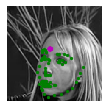

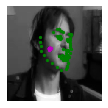

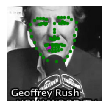

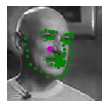

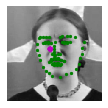

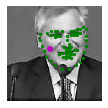

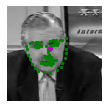

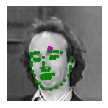

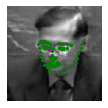

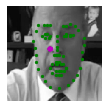

In [13]:
# visualize the output
# by default this shows a batch of 10 images
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=10):

    for i in range(batch_size):
        plt.figure(figsize=(20,10))
        ax = plt.subplot(1, batch_size, i+1)

        # un-transform the image data
        image = test_images[i].data   # get the image from it's wrapper
        image = image.numpy()   # convert to numpy array from a Tensor
        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image

        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.numpy()
        # undo normalization of keypoints  
        predicted_key_pts = predicted_key_pts*50.0+100
        
        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]         
            ground_truth_pts = ground_truth_pts*50.0+100
        
        # call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)
            
        plt.axis('off')

    plt.show()
    
# call it
visualize_output(test_images, test_outputs, gt_pts)

## Training

#### Loss function
Training a network to predict keypoints is different than training a network to predict a class; instead of outputting a distribution of classes and using cross entropy loss, you may want to choose a loss function that is suited for regression, which directly compares a predicted value and target value. Read about the various kinds of loss functions (like MSE or L1/SmoothL1 loss) in [this documentation](http://pytorch.org/docs/master/_modules/torch/nn/modules/loss.html).

### Define the loss and optimization

Next, I'll define how the model will train by deciding on the loss function and optimizer.

---

In [14]:
## Define the loss and optimization
import torch.optim as optim

criterion = nn.SmoothL1Loss()

## Define the optimizer
optimizer = optim.Adam(net.parameters(), lr = 0.001)
## I used this to shift all the optimizer values to GPU
for state in optimizer.state.values():
    for k, v in state.items():
        if isinstance(v, torch.Tensor):
            state[k] = v.cuda()

## Training and Initial Observation

Now, let's train on some batched training data from `train_loader` for a number of epochs. 

In [15]:
def train_net(n_epochs, device = device):

    # prepare the net for training
    net.to(device)
    net.train()
    training_loss = []

    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        running_loss = 0.0

        # train on batches of data
        for batch_i, data in enumerate(train_loader):
            # get the input images and their corresponding labels
            images = data['image']
            key_pts = data['keypoints']
            
            

            # flatten pts
            key_pts = key_pts.view(key_pts.size(0), -1)

            # convert variables to floats for regression loss
            key_pts = key_pts.type(torch.FloatTensor)
            images = images.type(torch.FloatTensor)
            
            images, key_pts = images.to(device), key_pts.to(device)

            # forward pass to get outputs
            output_pts = net(images)

            # calculate the loss between predicted and target keypoints
            loss = criterion(output_pts, key_pts)

            # zero the parameter (weight) gradients
            optimizer.zero_grad()
            
            # backward pass to calculate the weight gradients
            loss.backward()

            # update the weights
            optimizer.step()

            # print loss statistics
            # to convert loss into a scalar and add it to the running_loss, use .item()
            running_loss += loss.item()
            
            if batch_i % 100 == 99:    # print every 100 batches
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, running_loss/100))
                running_loss = 0.0
        training_loss.append(running_loss)

    print('Finished Training')
    return training_loss

In [16]:
# train your network
n_epochs = 15 # start small, and increase when you've decided on your model structure and hyperparams


training_loss = train_net(n_epochs)

Epoch: 1, Batch: 100, Avg. Loss: 0.12003856536000967
Epoch: 1, Batch: 200, Avg. Loss: 0.08838276781141757
Epoch: 1, Batch: 300, Avg. Loss: 0.0909900737553835
Epoch: 2, Batch: 100, Avg. Loss: 0.07812392085790634
Epoch: 2, Batch: 200, Avg. Loss: 0.08134864374995232
Epoch: 2, Batch: 300, Avg. Loss: 0.07001434260979295
Epoch: 3, Batch: 100, Avg. Loss: 0.06482606949284672
Epoch: 3, Batch: 200, Avg. Loss: 0.05204920558258891
Epoch: 3, Batch: 300, Avg. Loss: 0.044049704782664775
Epoch: 4, Batch: 100, Avg. Loss: 0.03690321307629347
Epoch: 4, Batch: 200, Avg. Loss: 0.03505333702079952
Epoch: 4, Batch: 300, Avg. Loss: 0.032795384963974356
Epoch: 5, Batch: 100, Avg. Loss: 0.02851146868430078
Epoch: 5, Batch: 200, Avg. Loss: 0.029239147803746163
Epoch: 5, Batch: 300, Avg. Loss: 0.02317989696748555
Epoch: 6, Batch: 100, Avg. Loss: 0.024636420039460063
Epoch: 6, Batch: 200, Avg. Loss: 0.021717769149690865
Epoch: 6, Batch: 300, Avg. Loss: 0.020404850114136935
Epoch: 7, Batch: 100, Avg. Loss: 0.019284

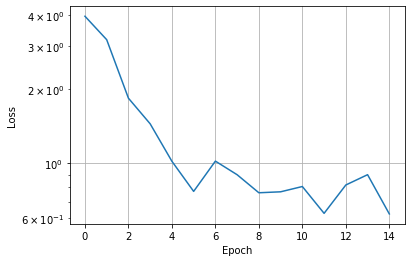

In [17]:
## Plot the loss to analyse model performance
plt.figure()
plt.semilogy(training_loss)
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Loss');

## Test data

See how the model performs on previously unseen, test data. I've already loaded and transformed this data, similar to the training data. Next, run the trained model on these images to see what kind of keypoints are produced. It can be seen if the model is fitting each new face it sees, if the points are distributed randomly, or if the points have actually overfitted the training data and do not generalize.

In [18]:
# get a sample of test data again

test_images, test_outputs, gt_pts = net_sample_output()

print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([10, 1, 224, 224])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


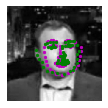

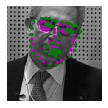

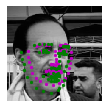

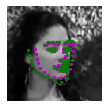

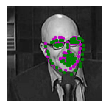

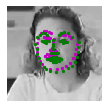

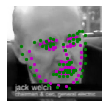

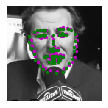

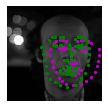

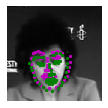

In [19]:
## visualize the test output

visualize_output(test_images, test_outputs, gt_pts)

Once a good model (or two) is found, save the model so it can be loaded and used later!

In [20]:
## change the name to something uniqe for each new model
model_dir = 'saved_models/'
model_name = 'keypoints_model_3.pt'

# after training, save your model parameters in the dir 'saved_models'
torch.save(net.state_dict(), model_dir+model_name)

In [21]:
net = Net()
net.load_state_dict(torch.load('saved_models/keypoints_model_3.pt'))
print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=30976, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=1000, bias=True)
  (fc3): Linear(in_features=1000, out_features=136, bias=True)
  (drop1): Dropout(p=0.2, inplace=False)
  (drop2): Dropout(p=0.2, inplace=False)
)


## Some Insights
---

### Q.1 What optimization and loss functions did I choose and why?


**Answer**: I tried following optimization and loss functions -

 *Loss Functions:*
 
 - *MSELoss* - I tried using Mean Squared Error Loss function, often known as L2 squared Norm. The squaring of the difference of prediction and actual value means that we’re amplifying large losses. This penalizes the model when it makes large mistakes and incentivizes small errors. Although, it is not so efficient with high-dimensional data like images.
 - **SmoothL1Loss** - This function performed much better compared to MSELoss function. It uses a squared term if the absolute error falls below 1 and an absolute term otherwise. It is less sensitive to outliers than the mean square error loss and in some cases prevents exploding gradients. In mean square error loss, we square the difference which results in a number which is much larger than the original number. These high values result in exploding gradients. This is avoided here as for numbers greater than 1, the numbers are not squared. It is well suited for most regression problems. 
 
*Optimization Functions:*
 
 - *Stochastic Gradient Optimizer* - It performs a parameter update for each training example unlike normal Gradient Descent which performs only one update. Thus it is much faster. Gradient Decent algorithms can further be improved by tuning important parametes like momentum, learning rate etc.
 - **Adam Optimizer** - Adam stands for Adaptive Moment Estimation. It also calculates different learning rate. Adam works well in practice, is faster, and outperforms other techniques. Thus, it was an obvious choice over SGD.

### Q.2 What kind of network architecture did I start with and how did it change as I tried different architectures? Did I decide to add more convolutional layers or any layers to avoid overfitting the data?

**Answer**: 
- TestModel 1 - In the beginning, I started with including 5 convolutional layers with decreasing kernel size. I also included dropout layer with an increasing probability of 0.1 between each convolution layer and the fully-connected layers. But, it performed very poorly.
- TestModel 2 - Then, I tried with 4 convolutional layers with decreasing kernal size. Dropout layers were same as before. It performed much better than the 1st model. But, it was highly overfitting.
- TestModel 3 - I tried experimenting with the dropout layers probability. Increasing probability was not giving good results. So, I trained the model with constant dropout probability of 0.2. Surprisingly, it performed better with loss decreasing rapidly.
- TestModel 4 (Final) - This time, I tried removing the dropout layers b/w the convolutional layers and retaining them only b/w fully connected layers. I also experimented with dimensions of Linear layers. This model performed excellent compared to all the 3 before. Hence, I decided to retain this model as a final one.

### Q.3: How did I decide on the number of epochs and batch_size to train the model?

**Answer**: I decided to increase my nepochs to 15 as the model was greatly decreasing the loss and batch_size of 10 images is sufficient for a good variance and is not computationally taxing.

## Feature Visualization

Sometimes, neural networks are thought of as a black box, given some input, they learn to produce some output. CNN's are actually learning to recognize a variety of spatial patterns and you can visualize what each convolutional layer has been trained to recognize by looking at the weights that make up each convolutional kernel and applying those one at a time to a sample image. This technique is called feature visualization and it's useful for understanding the inner workings of a CNN.

In the cell below, a single filter (by index) from the first convolutional layer is extracted. The filter should appear as a grayscale grid.

[[ 0.26171803  0.0528893  -0.10621841 -0.05791609  0.05042084]
 [-0.04316907  0.09929124  0.07055076 -0.14958845  0.00195027]
 [ 0.15746465  0.1789791  -0.18449433  0.07738476 -0.17929254]
 [ 0.17059855  0.11624052 -0.17982346 -0.22275734  0.10544191]
 [-0.03249425  0.11552494 -0.07106728 -0.00809392 -0.20908809]]
(5, 5)


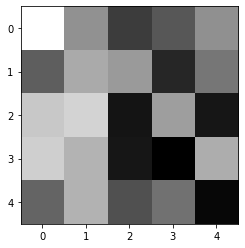

In [102]:
# Get the weights in the first conv layer, "conv1"
# if necessary, change this to reflect the name of your first conv layer
weights1 = net.conv1.weight.data

w = weights1.numpy()

filter_index = 5

print(w[filter_index][0])
print(w[filter_index][0].shape)

# display the filter weights
plt.imshow(w[filter_index][0], cmap='gray')

## Feature maps

Each CNN has at least one convolutional layer that is composed of stacked filters (also known as convolutional kernels). As a CNN trains, it learns what weights to include in it's convolutional kernels and when these kernels are applied to some input image, they produce a set of **feature maps**. So, feature maps are just sets of filtered images; they are the images produced by applying a convolutional kernel to an input image. These maps show us the features that the different layers of the neural network learn to extract. For example, you might imagine a convolutional kernel that detects the vertical edges of a face or another one that detects the corners of eyes. You can see what kind of features each of these kernels detects by applying them to an image. One such example is shown below; from the way it brings out the lines in an the image, you might characterize this as an edge detection filter.

<img src='images/feature_map_ex.png' width=50% height=50%/>


Next, choose a test image and filter it with one of the convolutional kernels in your trained CNN; look at the filtered output to get an idea what that particular kernel detects.

### TODO: Filter an image to see the effect of a convolutional kernel
---

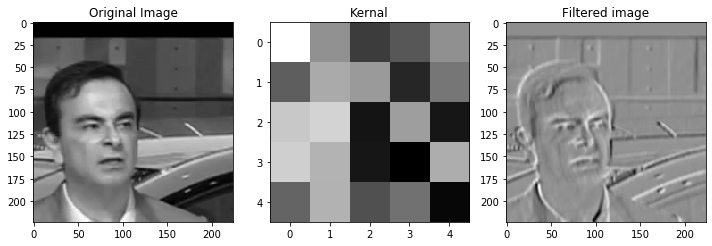

In [106]:
##TODO: load in and display any image from the transformed test dataset
test = test_dataset[6]
image = test['image']
image = image.type(torch.FloatTensor)
image = image.numpy()
image = np.squeeze(image)

kernal = w[filter_index][0]

filtered = cv2.filter2D(image, -1, kernal)

f, (ax1, ax2, ax3) = plt.subplots(ncols=3, nrows=1, figsize=(10, 5))
ax1.imshow(image, cmap='gray')
ax2.imshow(kernal, cmap='gray')
ax3.imshow(filtered, cmap='gray')

ax1.set_title('Original Image')
ax2.set_title('Kernal')
ax3.set_title('Filtered image')
plt.tight_layout();

As observed from the images above, the trained filter has learnt to detect diagonal edges quite successfully. It also successfully captures the edges of the facial features which are very crucial in predicting the facial keypoints accurately.

---
## Moving on!

Now that the model is trained (and saved the best model), in the last notebook, there is a combination of a face detector with the saved model to create a facial keypoint detection system that can predict the keypoints on *any* face in an image!